## Plot basin integrated air-sea CO2 fluxes from OTM runs with different priors using alternative layout and 5 cases

In [1]:
import xarray as xr
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Load BSP and other run data

Opt_result = xr.open_mfdataset('true_transports.nc')

yr_init=1992

month_init_early=(Opt_result.init_early-yr_init)*12
month_init_late=(Opt_result.init_late-yr_init)*12
Early_period = (np.array([month_init_early,month_init_early+Opt_result.dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+Opt_result.dyrs*12]))

dt = Opt_result.dt.values
dyrs = Opt_result.dyrs.astype('float64')


ECCO_BSP_data = xr.open_mfdataset(('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/tree_depth_6_BSP_ECCO/9_Basins_fluxerr_6/BSP_ECCO_monthly_*'))

Basins = ECCO_BSP_data.Basin.values

ECCO_time = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/ECCO-Darwin/ECCO_time.nc')
ECCO_dt=(np.hstack([ECCO_time.ECCO_time[0].values,np.diff(ECCO_time.ECCO_time)])).reshape(1,323,1)
ECCO_dt=ECCO_dt[:,0:ECCO_BSP_data.Time.size,:]


V_early = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
V_late = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Cflux_early = ((ECCO_BSP_data.Cflux_sum_hist)*ECCO_dt).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # mmol-C
Cflux_late = ((ECCO_BSP_data.Cflux_sum_hist)*ECCO_dt).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # mmol-C

Cflux_input = ((Cflux_late-Cflux_early)/(dyrs*(10**18/12))).values # units: PgC/yr

# Alternative way of calculating Cflux_input analagous to MTM_ECCO_monthly

#Cflux_cumsum = ((ECCO_BSP_data.Cflux_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
#                -((ECCO_BSP_data.Cflux_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C

#Cflux_input = Cflux_cumsum.sum('Depth')*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))/(dyrs*(10**18/12)).values


In [3]:
# OTM run with true CO2 flux prior

OTMrun='true'
Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

tree_depth=int(math.log2(Opt_result.tree_depth))

dC_Cflux = Opt_result.dC_Cflux


dC_adj_int = ((Opt_result.dC_adjustment.values.reshape(Basins.size,2**tree_depth)*V_late).sum(axis=1)/(dyrs*(10**18/12))).values
dC_Cflux_int = (np.reshape(dC_Cflux.values,(Basins.size,2**tree_depth))*V_early).sum(axis=1)/(dyrs.values*(10**18/12))


df_true = pd.DataFrame({'Prior': np.append(dC_Cflux_int, np.nansum(dC_Cflux_int)),\
                    'OTM': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
                   'ECCO-Darwin': np.append(Cflux_input, np.nansum(Cflux_input))},\
                  index = np.append(Basins, 'Global'))


C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [4]:
# OTM run with no prior

OTMrun='noprior'
Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

tree_depth=int(math.log2(Opt_result.tree_depth))

dC_Cflux = Opt_result.dC_Cflux


dC_adj_int = ((Opt_result.dC_adjustment.values.reshape(Basins.size,2**tree_depth)*V_late).sum(axis=1)/(dyrs*(10**18/12))).values
dC_Cflux_int = 0


df_noprior = pd.DataFrame({'Prior': np.append(np.zeros(dC_adj_int.size),0),\
                    'OTM': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
                   'ECCO-Darwin': np.append(Cflux_input, np.nansum(Cflux_input))},\
                  index = np.append(Basins, 'Global'))


In [5]:
# OTM run with upper bound biased prior

OTMrun='lb2_v2'
Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

tree_depth=int(math.log2(Opt_result.tree_depth))

dC_Cflux = Opt_result.dC_Cflux


dC_adj_int = ((Opt_result.dC_adjustment.values.reshape(Basins.size,2**tree_depth)*V_late).sum(axis=1)/(dyrs*(10**18/12))).values
dC_Cflux_int = (np.reshape(dC_Cflux.values,(Basins.size,2**tree_depth))*V_early).sum(axis=1)/(dyrs.values*(10**18/12))


df_lb = pd.DataFrame({'Prior': np.append(dC_Cflux_int, np.nansum(dC_Cflux_int)),\
                    'OTM': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
                   'ECCO-Darwin': np.append(Cflux_input, np.nansum(Cflux_input))},\
                  index = np.append(Basins, 'Global'))


C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [6]:
# OTM run with lower bound biased prior

OTMrun='ub2_v2'
Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

tree_depth=int(math.log2(Opt_result.tree_depth))

dC_Cflux = Opt_result.dC_Cflux


dC_adj_int = ((Opt_result.dC_adjustment.values.reshape(Basins.size,2**tree_depth)*V_late).sum(axis=1)/(dyrs*(10**18/12))).values
dC_Cflux_int = (np.reshape(dC_Cflux.values,(Basins.size,2**tree_depth))*V_early).sum(axis=1)/(dyrs.values*(10**18/12))


df_ub = pd.DataFrame({'Prior': np.append(dC_Cflux_int, np.nansum(dC_Cflux_int)),\
                    'OTM': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
                   'ECCO-Darwin': np.append(Cflux_input, np.nansum(Cflux_input))},\
                  index = np.append(Basins, 'Global'))


C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [7]:
# OTM run with enhanced errors prior

OTMrun='enhanced2xerr_v2'
Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

tree_depth=int(math.log2(Opt_result.tree_depth))

dC_Cflux = Opt_result.dC_Cflux


dC_adj_int = ((Opt_result.dC_adjustment.values.reshape(Basins.size,2**tree_depth)*V_late).sum(axis=1)/(dyrs*(10**18/12))).values
dC_Cflux_int = (np.reshape(dC_Cflux.values,(Basins.size,2**tree_depth))*V_early).sum(axis=1)/(dyrs.values*(10**18/12))


df_err = pd.DataFrame({'Prior': np.append(dC_Cflux_int, np.nansum(dC_Cflux_int)),\
                    'OTM': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
                   'ECCO-Darwin': np.append(Cflux_input, np.nansum(Cflux_input))},\
                  index = np.append(Basins, 'Global'))


C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


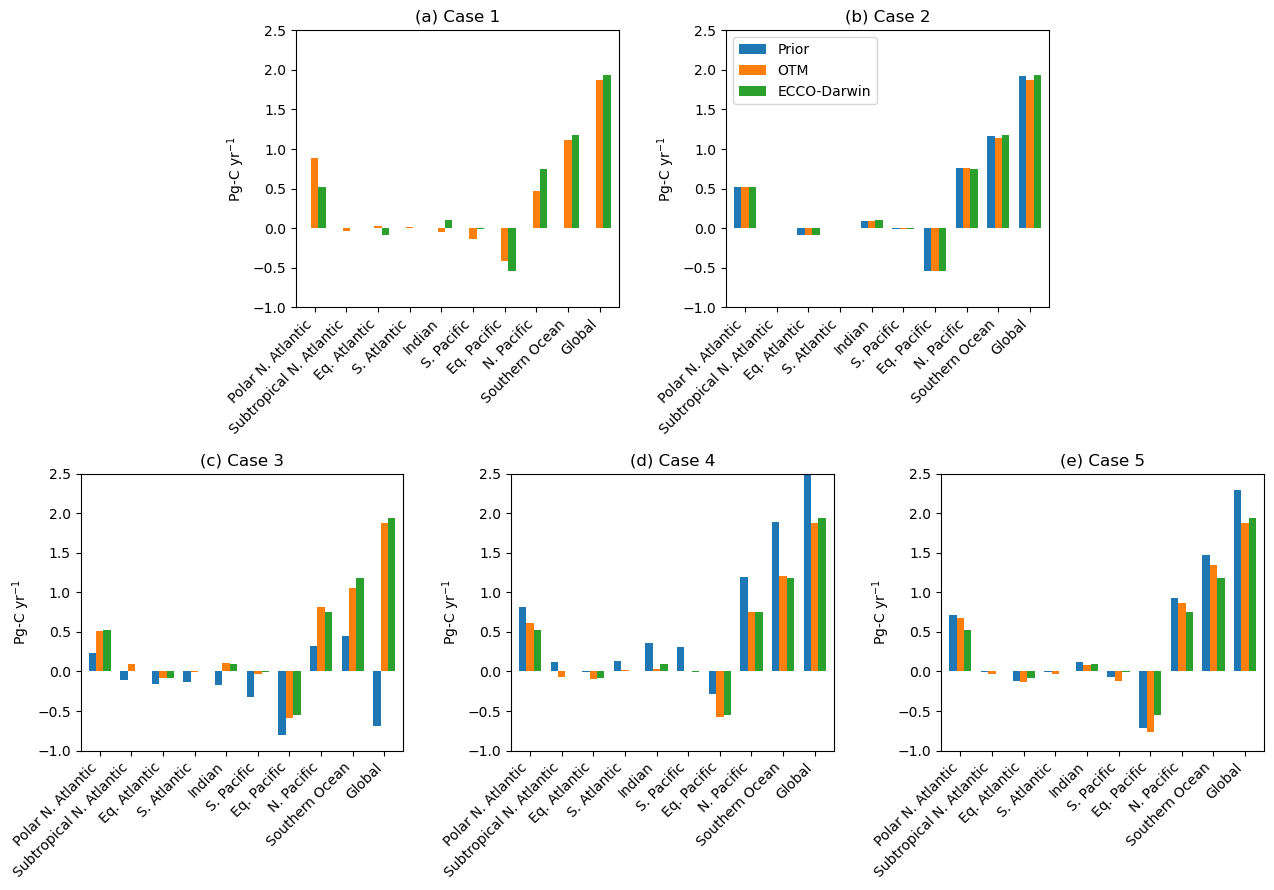

In [8]:
## Plot alternate layout

ylim=(-1,2.5)
w=0.7

fig = plt.figure(figsize=(14,9))
gs = gridspec.GridSpec(2,12, width_ratios=[1,1,1,1,1,1,1,1,1,1,1,1], height_ratios=[1,1])

ax1 = plt.subplot(gs[0, 2:5])
ax2 = plt.subplot(gs[0, 6:9])
ax3 = plt.subplot(gs[1, 0:3])
ax4 = plt.subplot(gs[1, 4:7])
ax5 = plt.subplot(gs[1, 8:11])

df_noprior.plot(kind='bar',ax=ax1,rot=45,legend=False,width=w)
ax1.set_ylabel('Pg-C yr$^{-1}$')
ax1.set_title('(a) Case 1')
ax1.set_ylim(ylim)
ax1.set_xticks(np.arange(len(df_noprior.index)))  # Set tick positions
ax1.set_xticklabels(df_noprior.index, ha="right")  # Use 'ha' to align right

ax2 = df_true.plot(kind='bar',ax=ax2,rot=45,width=w)
ax2.set_ylabel('Pg-C yr$^{-1}$')
ax2.set_title('(b) Case 2')
ax2.set_ylim(ylim)
ax2.legend(loc='upper left')

ax2.set_xticks(np.arange(len(df_noprior.index)))  # Set tick positions
ax2.set_xticklabels(df_noprior.index, ha="right")  # Use 'ha' to align right

ax3 = df_lb.plot(kind='bar',ax=ax3,rot=45,legend=False,width=w)
ax3.set_ylabel('Pg-C yr$^{-1}$')
ax3.set_title('(c) Case 3')
ax3.set_ylim(ylim)
ax3.set_xticks(np.arange(len(df_noprior.index)))  # Set tick positions
ax3.set_xticklabels(df_noprior.index, ha="right")  # Use 'ha' to align right

ax4 = df_ub.plot(kind='bar',ax=ax4,rot=45,legend=False,width=w)
ax4.set_ylabel('Pg-C yr$^{-1}$')
ax4.set_title('(d) Case 4')
ax4.set_ylim(ylim)
ax4.set_xticks(np.arange(len(df_noprior.index)))  # Set tick positions
ax4.set_xticklabels(df_noprior.index, ha="right")  # Use 'ha' to align right

ax5 = df_err.plot(kind='bar',ax=ax5,rot=45,legend=False,width=w)
ax5.set_ylabel('Pg-C yr$^{-1}$')
ax5.set_title('(e) Case 5')
ax5.set_ylim(ylim)
ax5.set_xticks(np.arange(len(df_noprior.index)))  # Set tick positions
ax5.set_xticklabels(df_noprior.index, ha="right")  # Use 'ha' to align right


plt.tight_layout()

plt.subplots_adjust(hspace = 0.6)
plt.subplots_adjust(wspace = 0)


plt.savefig('allpriors_carbon_sink_alt.png', bbox_inches='tight', dpi=300, transparent=True)                                   


In [9]:
df_ub

,Prior,OTM,ECCO-Darwin
Polar N. Atlantic,0.812463,0.615615,0.526182
Subtropical N. Atlantic,0.115531,-0.066162,0.005648
Eq. Atlantic,-0.006592,-0.096490,-0.081683
S. Atlantic,0.136484,0.014443,0.005461
Indian,0.361596,0.033452,0.099583
S. Pacific,0.305268,0.008836,-0.005535
Eq. Pacific,-0.281392,-0.578275,-0.543994
N. Pacific,1.193259,0.745268,0.751283
Southern Ocean,1.890201,1.200975,1.179660
Global,4.526819,1.877662,1.936606
